In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import sparse
import os
import random

In [7]:
tf.__version__

'2.1.0'

# Read Data

In [8]:
path = 'C:/Users/robin.opdam/Dropbox/'
# path = '/Users/Robin/Dropbox'
data_path = 'data/'

## Amazon Fashion

In [9]:
#Full data
# file_name = 'amazon_clothing_shoes_jewelry_data' 

#2m user above 5 ratings
# file_name = 'amazon_csj_2m'

#0.63m user above 5 ratings
# file_name = 'df_amazon_csj_with_styles_0.63m_u_above_5_rui' 

## MovieLens

In [10]:
# Full data
# file_name = 'ml-25m'

# 2m subset
# file_name = '2m-ml'

# 0.7m subset
# file_name = 'ml_0.7_u_above_5'

## Time sorted ml 2m dataset

In [11]:
# 6000 users sorted on datetime per user
file_name = 'ml_6k_users'

#0.7m rows sorted per user on datetime
# file_name = 'ml_07m_sorted'

In [12]:
df = pd.read_pickle(path + data_path + file_name)
df.head()

,user,item,rating,timestamp,user_id,item_id
5258074,34161,4993,4.0,2018-12-28 02:15:28,34160,4887
5258067,34161,1210,4.0,2018-12-28 02:18:16,34160,1179
5258069,34161,2571,4.0,2018-12-28 02:18:44,34160,2480
5258086,34161,59315,4.0,2018-12-28 02:19:04,34160,12319
5258075,34161,5502,5.0,2018-12-28 02:19:28,34160,5394


In [13]:
df['user_id'] = df.user.astype('category').cat.codes
df['item_id'] = df.item.astype('category').cat.codes

## Leave users out 

In [14]:
def leave_users_out(full_data, leave_out):
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [15]:
# leftovers, new_df = leave_users_out(df, 6000)

# Data Exploration

First filtering active users and rated items with x or more ratings:

In [16]:
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

rows  904023 
#ratings 904023 
#ratings/user 150.67 
#ratings/item 38.7 
average rating 3.54 
#users  6000 
#items  23362 
sparse  0.99355 %


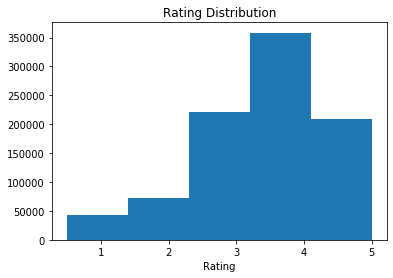

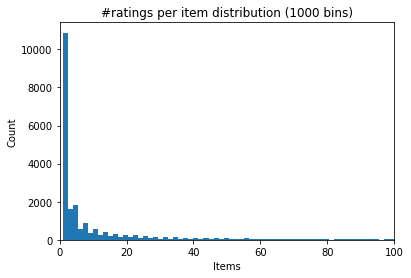

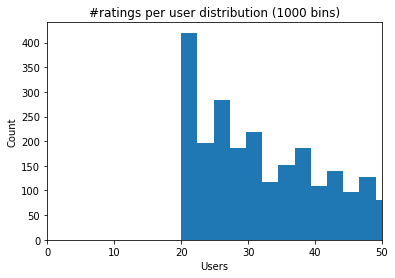

In [17]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')

df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 2000)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 2000)
plt.xlim([0,50])
plt.title('#ratings per user distribution (1000 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks

- paper: https://arxiv.org/pdf/1608.07400.pdf
- code:https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Data Prep

Create 100 people **train df**

In [18]:
df_og = df

In [19]:
test_users = 500
df, test_df = leave_users_out(df_og, test_users)
df['item_id'] = df.item_id.astype('category').cat.codes
df['user_id'] = df.user_id.astype('category').cat.codes
n_items = len(df_og.item_id.unique())

print('total number of items:', n_items)
print('total users:', len(df_og.user_id.unique()))
print('number of train users:', len(df.user_id.unique()))
print('number of test users:', test_users)

total number of items: 23362
total users: 6000
number of train users: 5500
number of test users: 500


---
### Train and Target sequences
Create the **sequences** from the item_ids per user (already sorted)

In [20]:
user_sequences_x = []
user_sequences_y = []

lengths = []
for u in df.user_id.unique():
    user_item_seq = np.array(df[df['user_id']==u]['item_id'])
    user_sequences_x.append(user_item_seq[:-1])
    user_sequences_y.append(user_item_seq[1:])
    lengths.append(len(user_item_seq))
print('number of sequences x:', len(user_sequences_x), 
      '\navg sequence length x:', np.average(lengths),
      '\nstd_dev sequence length x:', np.round(np.std(lengths),2))

number of sequences x: 5500 
avg sequence length x: 151.31727272727272 
std_dev sequence length x: 260.8


In [21]:
user_sequences_x[0]

array([ 4699,  1155,  2429, 10693,  5165, 22122,  3988,   306,   250,
       22125, 10243,  8965,  3289,  2613, 22666,  5406,  7344,  5305,
        8632, 12178, 11348, 13542,  9527,  2364,   142, 22660, 10566,
        3723,  9843, 16292, 16291, 13133, 10440, 14857, 13727],
      dtype=int16)

In [22]:
user_sequences_y[0]

array([ 1155,  2429, 10693,  5165, 22122,  3988,   306,   250, 22125,
       10243,  8965,  3289,  2613, 22666,  5406,  7344,  5305,  8632,
       12178, 11348, 13542,  9527,  2364,   142, 22660, 10566,  3723,
        9843, 16292, 16291, 13133, 10440, 14857, 13727, 15288],
      dtype=int16)

---
### Padding
**pad** the sequences (needed for rectangular tf.data.Dataset):
- add zeros if they are too short
- remove item ids from the beginning if they are too long

In [23]:
max_length = 250
padded_sequences_x = tf.keras.preprocessing.sequence.pad_sequences(user_sequences_x, maxlen=max_length, padding='post', truncating='pre')
padded_sequences_y = tf.keras.preprocessing.sequence.pad_sequences(user_sequences_y, maxlen=max_length, padding='post', truncating='pre')
print('number of sequences x:', padded_sequences_x.shape[0], 
      '\navg sequence length x:', np.average([i.shape[0] for i in padded_sequences_x]),
      '\nstd_dev sequence length x:', np.std([i.shape[0] for i in padded_sequences_x]))


number of sequences x: 5500 
avg sequence length x: 250.0 
std_dev sequence length x: 0.0


---
### Create Dataset
**create batch dataset**
- sequences_x inputs
- sequences_y actuals
- batches of size BATCH_SIZE

In [24]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

#normal sequence input
sequences_data_x = tf.data.Dataset.from_tensor_slices(padded_sequences_x) 
sequences_data_y = tf.data.Dataset.from_tensor_slices(padded_sequences_y) 
dataset = tf.data.Dataset.zip((sequences_data_x, sequences_data_y))
dataset

<ZipDataset shapes: ((250,), (250,)), types: (tf.int32, tf.int32)>

In [25]:
for input_example, target_example in  dataset.take(1).as_numpy_iterator():
    print ('Input data: ', input_example)
    print ('Target data:', target_example)

Input data:  [ 4699  1155  2429 10693  5165 22122  3988   306   250 22125 10243  8965
  3289  2613 22666  5406  7344  5305  8632 12178 11348 13542  9527  2364
   142 22660 10566  3723  9843 16292 16291 13133 10440 14857 13727     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [26]:
BATCH_SIZE = 100
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
for i, o in dataset.take(1).as_numpy_iterator():
    print('input:', i.shape, '\n\noutput:', o.shape)

input: (100, 250) 

output: (100, 250)


--- 
## Model Prep

**model architecture**

In [46]:
def build_model(n_items, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(n_items, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(units=rnn_units,
                             return_sequences=True,
                             stateful=False, #Reset cell states with each batch
                             recurrent_initializer='glorot_uniform'),
        
        tf.keras.layers.Dense(n_items)
    ])
    return model

---
**build model**

In [47]:
embedding_dim = 100
rnn_units = 20

In [48]:
model = build_model(
n_items = n_items,
embedding_dim = embedding_dim,
rnn_units = rnn_units,
batch_size = BATCH_SIZE)

---
### Add Loss
<br>
one hot encode labels for dimensionality match of LSTM output
<br> 
**Added one hot encoding of the labels to match logits output after dense layer**

In [49]:
def loss(labels, logits):
    oh_labels = tf.keras.backend.one_hot(tf.dtypes.cast(labels, tf.int32), n_items)
    return tf.keras.losses.categorical_crossentropy(oh_labels, logits, from_logits=True)

model.compile(optimizer='Adagrad', loss=loss)

---
## Try Model

In [31]:
dataset.take(1)

<TakeDataset shapes: ((None, 250), (None, 250)), types: (tf.int32, tf.int32)>

In [32]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_preds = model(input_example_batch)
    print(example_batch_preds.shape, "# (batch_size, sequence_length, n_items)")

(100, 250, 23362) # (batch_size, sequence_length, n_items)


In [33]:
example_batch_loss = loss(target_example_batch, example_batch_preds)

In [34]:
example_batch_preds.shape

TensorShape([100, 250, 23362])

In [35]:
example_batch_loss.shape

TensorShape([100, 250])

---
**model summmary**

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 100)          2336200   
_________________________________________________________________
lstm (LSTM)                  (100, None, 20)           9680      
_________________________________________________________________
dense (Dense)                (100, None, 23362)        490602    
Total params: 2,836,482
Trainable params: 2,836,482
Non-trainable params: 0
_________________________________________________________________


---
## Train Model

---
**Configure Checkpoints**

In [37]:
# Directory where the checkpoints will be saved
checkpoint_dir = './rnn_train_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

---
**Fit Model**

In [40]:
epochs = 100
dataset

<BatchDataset shapes: ((None, 250), (None, 250)), types: (tf.int32, tf.int32)>

In [41]:
history = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

Train for 55 steps
Epoch 1/100
55/55 [==============================] - 372s 7s/step - loss: 9.9489
Epoch 2/100
55/55 [==============================] - 371s 7s/step - loss: 9.6420
Epoch 3/100
55/55 [==============================] - 372s 7s/step - loss: 9.3998
Epoch 4/100
55/55 [==============================] - 368s 7s/step - loss: 9.2193
Epoch 5/100
54/55 [============================>.] - ETA: 7s - loss: 9.0735

KeyboardInterrupt: 

---
## Continue training from checkpoint

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (100, None, 100)          2336200   
_________________________________________________________________
lstm_4 (LSTM)                (100, None, 20)           9680      
_________________________________________________________________
dense_4 (Dense)              (100, None, 23362)        490602    
Total params: 2,836,482
Trainable params: 2,836,482
Non-trainable params: 0
_________________________________________________________________


In [62]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(n_items, embedding_dim, rnn_units, batch_size=100)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.compile(optimizer='Adagrad', loss=loss)

In [63]:
aditional_epochs = 1

In [64]:
model.fit(dataset, epochs=aditional_epochs, callbacks=[checkpoint_callback])

Train for 55 steps
 9/55 [===>..........................] - ETA: 5:50 - loss: 4.1975


KeyboardInterrupt



---
# Predict Sequences

## Restore Latest Checkpoints

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
model = build_model(n_items, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
                   
model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

---
## Create Predictions

**Using test_df**

In [69]:
print('test users:', len(test_df.user_id.unique()))

test users: 500


In [ ]:
predictions_df = pd.DataFrame(columns=['user', 'pred_seq', 'true_seq'])

In [ ]:
temperature = 1.0

for u in test_df.user_id.unique(): #Note: Can use multiprocessing for this
    generated_predictions = []
    user_item_seq = np.array(test_df[test_df['user_id']==u]['item_id'])
    half_test_seq = user_item_seq[:int(len(user_item_seq)/2)]
    half_test_seq = half_test_seq.reshape(-1,1).transpose()
    other_half = user_item_seq[int(len(user_item_seq)/2):]

    #Predict
    for item in half_test_seq[0]:
        predictions = model(half_test_seq)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        half_test_seq = np.append(half_test_seq, predicted_id).reshape(-1,1).transpose()

        half_test_seq = tf.expand_dims([predicted_id], 0)
        generated_predictions.append(predicted_id)
        
    predictions_df = predictions_df.append({'user':u, 'pred_seq':generated_predictions, 'true_seq':other_half}, ignore_index=True)

In [ ]:
len(predictions_df.iloc[0]['true_seq'])

# Evaluate

In [70]:
result_path = 'Results/CFRNN/'
predictions = pd.read_pickle(path + result_path + 'CFRNN_ml_6k_users_700_epochs')

In [79]:
list(predictions)

['user', 'pred_seq', 'true_seq']

In [82]:
hitcount = 0
for i, row in predictions.iterrows():
    for true_item in row.true_seq:
        if true_item in row.pred_seq:
            hitcount += 1
            print(row.user, true_item)

1108 1841
2448 148
5552 10204
5552 9145
5854 2313
5135 46
5135 21015
5135 1880
4620 7300
1208 133
1373 6354
602 6892
602 18287
602 4246
602 3614
602 4005
602 5518
602 14551
602 9912
602 19011
602 3265
602 12593
602 14227
602 2018
602 1040
602 1159
602 644
602 6615
602 16919
602 5083
602 20933
1192 3120
1192 68
1192 5060
1192 7385
1192 5180
1192 1552
1192 11481
1192 13450
1192 14588
1192 14642
3355 965
3355 1147
3355 650
2040 1142
5600 0
920 2554
5485 2768
2733 1289
2733 7320
2733 5000
2733 1405
2733 6091
2733 5501
2733 5130
2733 2929
2733 7701
2733 9226
2733 1605
2310 5121
4394 22
525 1534
4851 466
3857 1166
3857 5082
3857 5899
2103 2326
2103 2235
2418 2767
2418 1947
2418 3886
934 5149
934 3748
934 998
5908 442
2698 3320
145 4792
145 3642
145 6353
145 106
5565 9501
1540 1232
1540 3847
1540 210
1540 5558
1540 746
1540 1590
1540 3979
5929 442
3864 8562
3864 984
3864 242
3864 649
3864 291
3864 3492
2346 2543
4801 1234
4801 1216
305 6121
1638 2848
4485 5498
4485 1986
4485 1830
4485 7228
44

In [81]:
hitcount

485

# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)